In [1]:
import cPickle
import gzip

from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from breze.learn.utils import tile_raster_images

import climin.stops


import climin.initialize

from breze.learn import sgvb
from matplotlib import pyplot as plt
from matplotlib import cm

import numpy as np

#import fasttsne

#from IPython.html import widgets
%matplotlib inline 

import theano
import theano.tensor as T
theano.config.compute_test_value = 'ignore'#'raise'

In [2]:
datafile = '../mnist.pkl.gz'
# Load data.                                                                                                   

with gzip.open(datafile,'rb') as f:                                                                        
    train_set, val_set, test_set = cPickle.load(f)                                                       

X, Z = train_set                                                                                               
VX, VZ = val_set
TX, TZ = test_set

Z = one_hot(Z, 10)
VZ = one_hot(VZ, 10)
TZ = one_hot(TZ, 10)

image_dims = 28, 28

X, Z, VX, VZ, TX, TZ = [cast_array_to_local_type(i) for i in (X, Z, VX,VZ, TX, TZ)]

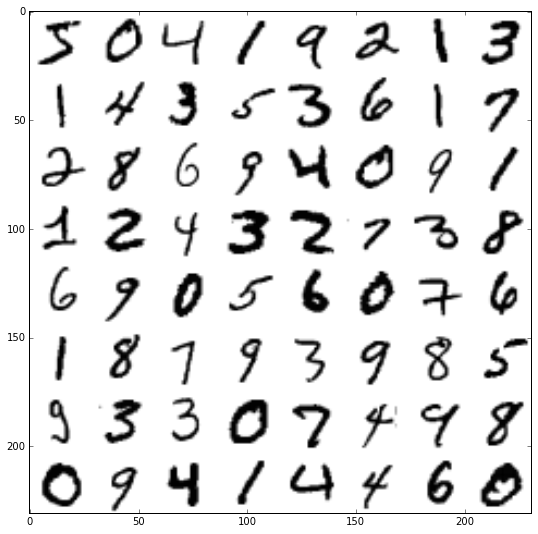

In [3]:
fig, ax = plt.subplots(figsize=(9, 9))

img = tile_raster_images(X[:64], image_dims, (8, 8), (1, 1))
ax.imshow(img, cmap=cm.binary)

In [4]:
from breze.arch.construct.layer.distributions import NormalGauss
from breze.arch.construct.neural.distributions import PlanarNormalizingFlowMlpDiagGauss

class PlanarNormalizingFlowLatentVAEMixin(object):

    def make_prior(self, sample):
        return NormalGauss(sample.shape)

    def make_recog(self, inpt):
        return PlanarNormalizingFlowMlpDiagGauss(
            inpt, self.n_inpt,
            [128] * 2, self.n_latent, ['sigmoid'] * 2,
            'identity', 3,
            declare=self.parameters.declare)

In [5]:
batch_size = 200
#optimizer = 'rmsprop', {'step_rate': 1e-4, 'momentum': 0.95, 'decay': .95, 'offset': 1e-6}
#optimizer = 'adam', {'step_rate': .5, 'momentum': 0.9, 'decay': .95, 'offset': 1e-6}
optimizer = 'adam'

reload(sgvb)

class MyVAE(sgvb.VariationalAutoEncoder,
            PlanarNormalizingFlowLatentVAEMixin, 
            sgvb.MlpBernoulliVisibleVAEMixin, 
            ):
    pass
kwargs = {}

# This is the number of random variables NOT the size of 
# the sufficient statistics for the random variables.
n_latents = 64
n_hidden = 512

m = MyVAE(X.shape[1], [n_hidden], n_latents, [n_hidden], ['rectifier'] * 1, ['rectifier'] * 1,
          optimizer=optimizer, batch_size=batch_size,
          **kwargs)

climin.initialize.randomize_normal(m.parameters.data, 0, 1e-2)

m.estimate_nll(X[:10])

In [39]:
max_passes = 250
max_iter = max_passes * X.shape[0] / batch_size
n_report = X.shape[0] / batch_size

stop = climin.stops.AfterNIterations(max_iter)
pause = climin.stops.ModuloNIterations(n_report)

for i, info in enumerate(m.powerfit((X,), (VX[:1],), stop, pause)):
    print i, info['loss'], info['val_loss']


0 116.078025312 99.8517746031
1 115.933345189 108.833989091
2 115.669632153 99.3511568308
3 115.408719232 118.485179611
4 115.416290968 104.786369093
5 115.195997102 112.675709456
6 114.945672787 122.770116478
7 114.868967269 108.082212538
8 114.570972963 103.315897986
9 114.554894057 108.800712049
10 114.285696141 97.1136053056
11 114.053468888 106.23836045
12 114.252649509 108.302253157
13 113.932683112 96.6123391837
14 113.605801025 105.302606612
15 113.492034219 109.933262669
16 113.419720666 101.675987609
17 113.086636925 108.720444694
18 113.075206079 102.159422554
19 112.962877946 98.3671886921
20 112.687321226 107.053253584
21 112.475929093 111.551753573
22 112.218189994 108.872759789
23 112.030942378 112.958096698
24 111.979818704 99.9869645983
25 111.854823479 108.401795775
26 111.754136966 106.588992938
27 111.607217745 90.7022429332
28 111.392299792 102.746963747
29 111.212937272 103.997741982
30 111.164142079 99.441428028
31 110.924820173 99.8143670782
32 110.726442649 106

m.parameters.data[...] = info['best_pars']

In [40]:
f_sample = m.function([m.recog_sample], m.vae.gen.sample())
f_recons = m.function(['inpt'], m.vae.gen.sample())

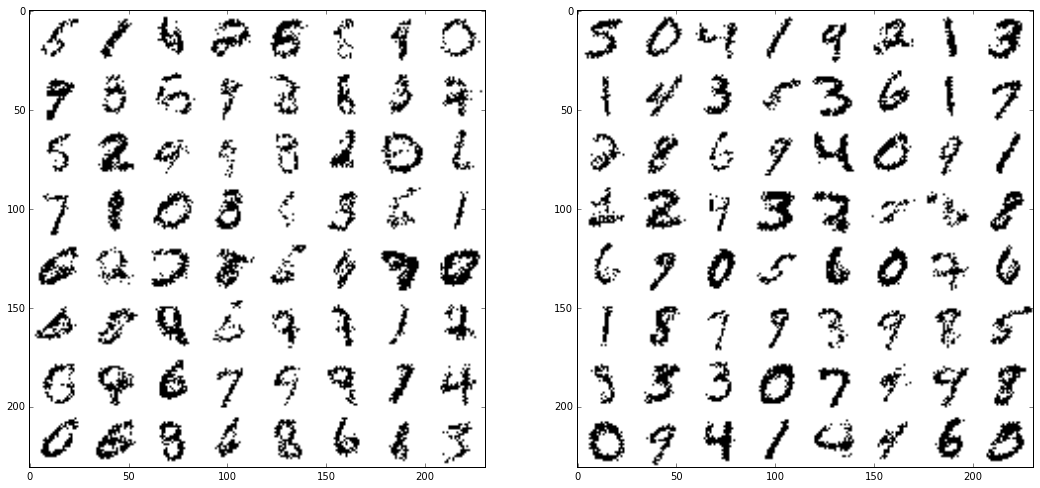

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

S = f_sample(np.random.randn(64, m.n_latent).astype('float32'))[:, :784].astype('float32')
img = tile_raster_images(S, image_dims, (8, 8), (1, 1))
axs[0].imshow(img, cmap=cm.binary)

R = f_recons(X[:64])[:, :784].astype('float32')
img = tile_raster_images(R, image_dims, (8, 8), (1, 1))

axs[1].imshow(img, cmap=cm.binary)

fig, axs = plt.subplots(1, 2, figsize=(18, 9))
img = tile_raster_images(m.parameters[m.vae.recog.mlp.layers[0].weights].T, image_dims, (10, 10), (1, 1))
axs[0].imshow(img, cmap=cm.binary)

img = tile_raster_images(m.parameters[m.vae.gen.mlp.layers[-1].weights], image_dims, (10, 10), (1, 1))
axs[1].imshow(img, cmap=cm.binary)

In [42]:
f_L = m.function([m.vae.inpt], m.vae.recog.sample(), on_unused_input='ignore')
f_L_mean0 = m.function([m.vae.inpt], m.vae.recog.initial_dist.mean, on_unused_input='ignore')
f_L_var0 = m.function([m.vae.inpt], m.vae.recog.initial_dist.var, on_unused_input='ignore')

In [43]:
L = f_L(X)
L_mean0 = f_L_mean0(X)
L_var0 = f_L_var0(X)
L0 = L_mean0 + np.random.randn(*L_mean0.shape) * np.sqrt(L_var0)

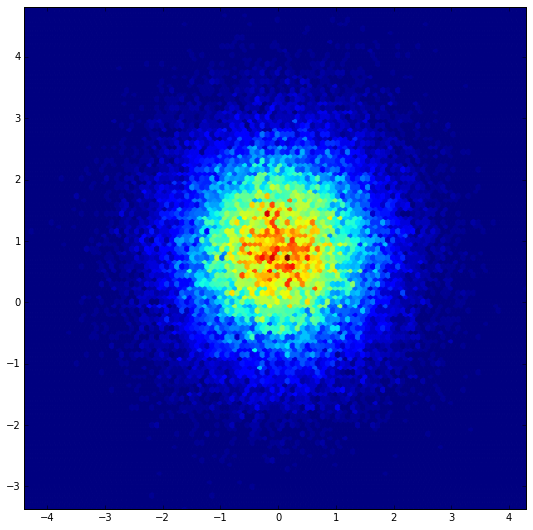

In [44]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.hexbin(L0[:, 0], L0[:, 1])

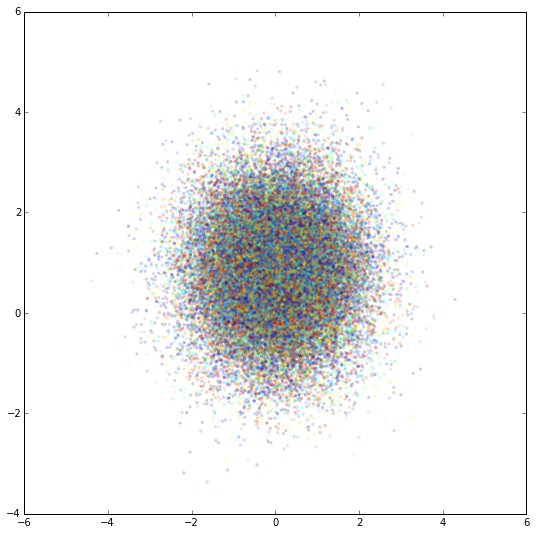

In [45]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.scatter(L0[:, 0], L0[:, 1], c=Z[:].argmax(1), lw=0, s=10, alpha=.2)

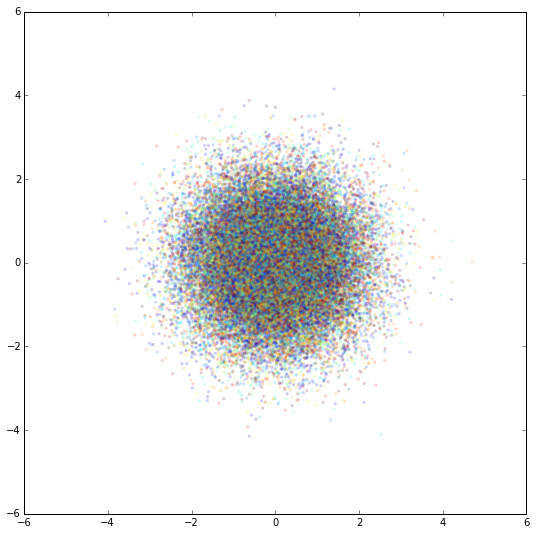

In [46]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.scatter(L[:, 0], L[:, 1], c=Z[:].argmax(1), lw=0, s=10, alpha=.2)